In [1]:
import pandas as pd
import numpy as np
import cv2
from skimage.transform import resize

### Reading Image Data

In [2]:
train=pd.read_csv("./sign_data/train_data.csv",header=None)

In [3]:
train.head()

,0,1,2
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
a=[]
j=1
for i in range(1000):
   # print(j)
    image=plt.imread("./sign_data/train/"+train[0][i])
    a.append(image)
    j=j+1

In [ ]:
b=[]
j=1
for i in range(1000):
   # print(j)
    image=plt.imread("./sign_data/train/"+train[1][i])
    b.append(image)
    j=j+1

In [13]:
a1=[resize(a[i], (120, 500)) for i in range(1000)]

In [14]:
b1=[resize(b[i], (120, 500)) for i in range(1000)]

### Creating Testing and Training Datasets

In [15]:
train_data=[list(x) for x in zip(a1, b1)]

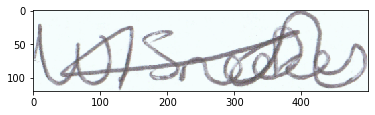

In [16]:
plt.imshow(train_data[0][0])

In [17]:
c=np.array(train_data)

In [18]:
y=[]
for i in range(1000):
    y.append(train[2][i])

### Model Building

In [19]:
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

Using TensorFlow backend.


In [20]:
input_shape=(120,500,3)
left_input = Input(input_shape)
right_input = Input(input_shape)

In [21]:
model = Sequential()
model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(128, (7,7), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (4,4), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (4,4), activation='relu'))
model.add(Flatten())
model.add(Dense(4096, activation='sigmoid'))

# Generate the encodings (feature vectors) for the two images
encoded_l = model(left_input)
encoded_r = model(right_input)

# Add a customized layer to compute the absolute difference between the encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

# Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1,activation='sigmoid')(L1_distance)

In [22]:
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

In [23]:
siamese_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 120, 500, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 120, 500, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         404913472   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]         

In [24]:
optimizer = Adam(lr = 0.00006)
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    #for match_group in [True, False]:
    group_idx = np.random.choice(all_groups, size = batch_halfsize)
    out_img_a += [in_groups[c_idx,0]for c_idx in group_idx]
#         if match_group:
#             b_group_idx = group_idx
#             out_score += [1]*batch_halfsize
#         else:
#             # anything but the same group
#             non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
#             b_group_idx = non_group_idx
#             out_score += [0]*batch_halfsize
            
    out_img_b += [in_groups[c_idx,1] for c_idx in group_idx]
    y=[in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.sta

In [27]:
train_data1=[list(x) for x in zip(a1, b1,y)]

In [28]:
tt=np.array(train_data1)

In [30]:
def siam_gen(train_data1,batch):
    while True:
        out_img_a=[]
        out_img_b=[]
        y=[]
        a2=np.random.choice(len(train_data1),size = batch)
        #for i in range(batch)
        out_img_a += [train_data1[c_idx,0] for c_idx in a2]
        out_img_b += [train_data1[c_idx,1] for c_idx in a2]
        y+=[train_data1[c_idx,2] for c_idx in a2]
        #b2=np.random.choice(np.array(b1),size = batch)
        #y1=np.random.choice(np.array(y,size = batch)
       # pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        
        yield [np.stack(out_img_a),np.stack(out_img_b)],np.stack(y)

In [ ]:
siamese_net.fit_generator(siam_gen(tt,batch=100), steps_per_epoch = 500,
                              # validation_split=0.2,
                                              epochs = 10,
                                             verbose = True)